# Projekt z przedmiotu Metody Klasyfikacji Danych Geoinformatycznych - Etap 2

### Analiza/klasyfikacja dowolnych obrazów za pomocą macierzy wspólnych wystąpień (Grey Level Co-occurence Matrices - GLCM)

#### Skład zespołu: Marta Dzięgielewska s176363, Maciej Gielert s176137

Link do etapu 1: https://docs.google.com/document/d/1HsTw6qhrXO0SoeWtg8hENvtkOi2oqkhV-VhOnhndA5s/edit?usp=sharing

In [1]:
# imports

import tensorflow as tf
import numpy as np
import skimage.transform
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage.color import label2rgb
from skimage.util import montage as montage2d
from skimage.feature import greycomatrix, greycoprops
import cv2
%matplotlib inline

Dataset do pobrania: https://www.robots.ox.ac.uk/~vgg/data/dtd/

In [2]:
# split the dataset

directory = "dtd/images"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    image_size=(256, 256),
    labels="inferred",
    shuffle=True,
    batch_size=32,
    seed=42)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    image_size=(256, 256),
    labels="inferred",
    shuffle=True,
    seed=42)

Found 5640 files belonging to 47 classes.
Using 4512 files for training.
Found 5640 files belonging to 47 classes.
Using 1128 files for validation.


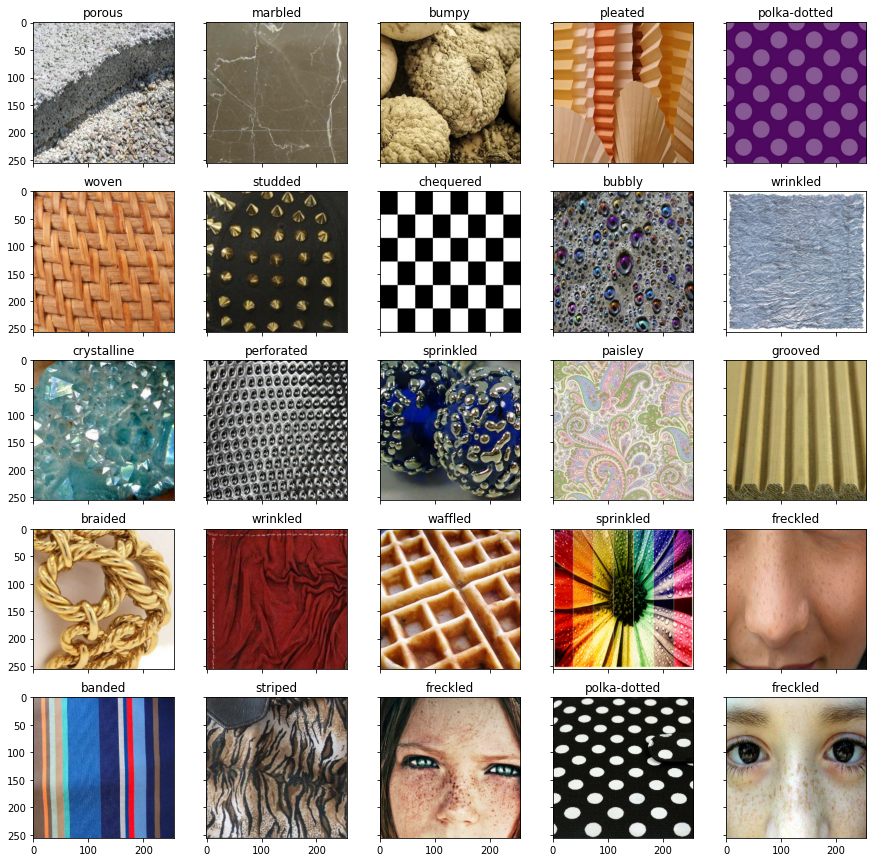

In [3]:
# example images and labels from dataset

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15,15))
 
for images, labels in train_ds.take(1):
    for i in range(5):
        for j in range(5):
            ax[i][j].imshow(images[i*5+j].numpy().astype("uint8"))
            ax[i][j].set_title(train_ds.class_names[labels[i*5+j]])
plt.show()

Do analizy wybraliśmy tekstury: prążkowaną, bąbelkową, popękaną, kropkowaną, siatkową, porowatą, rozmazaną, żyłkowatą i zygzakowatą.

In [4]:
# chosen 10 textures to analyze

textures = ['banded', 'bubbly', 'cracked', 'dotted', 'grid', 'meshed', 'porous', 'smeared', 'veined', 'zigzagged']

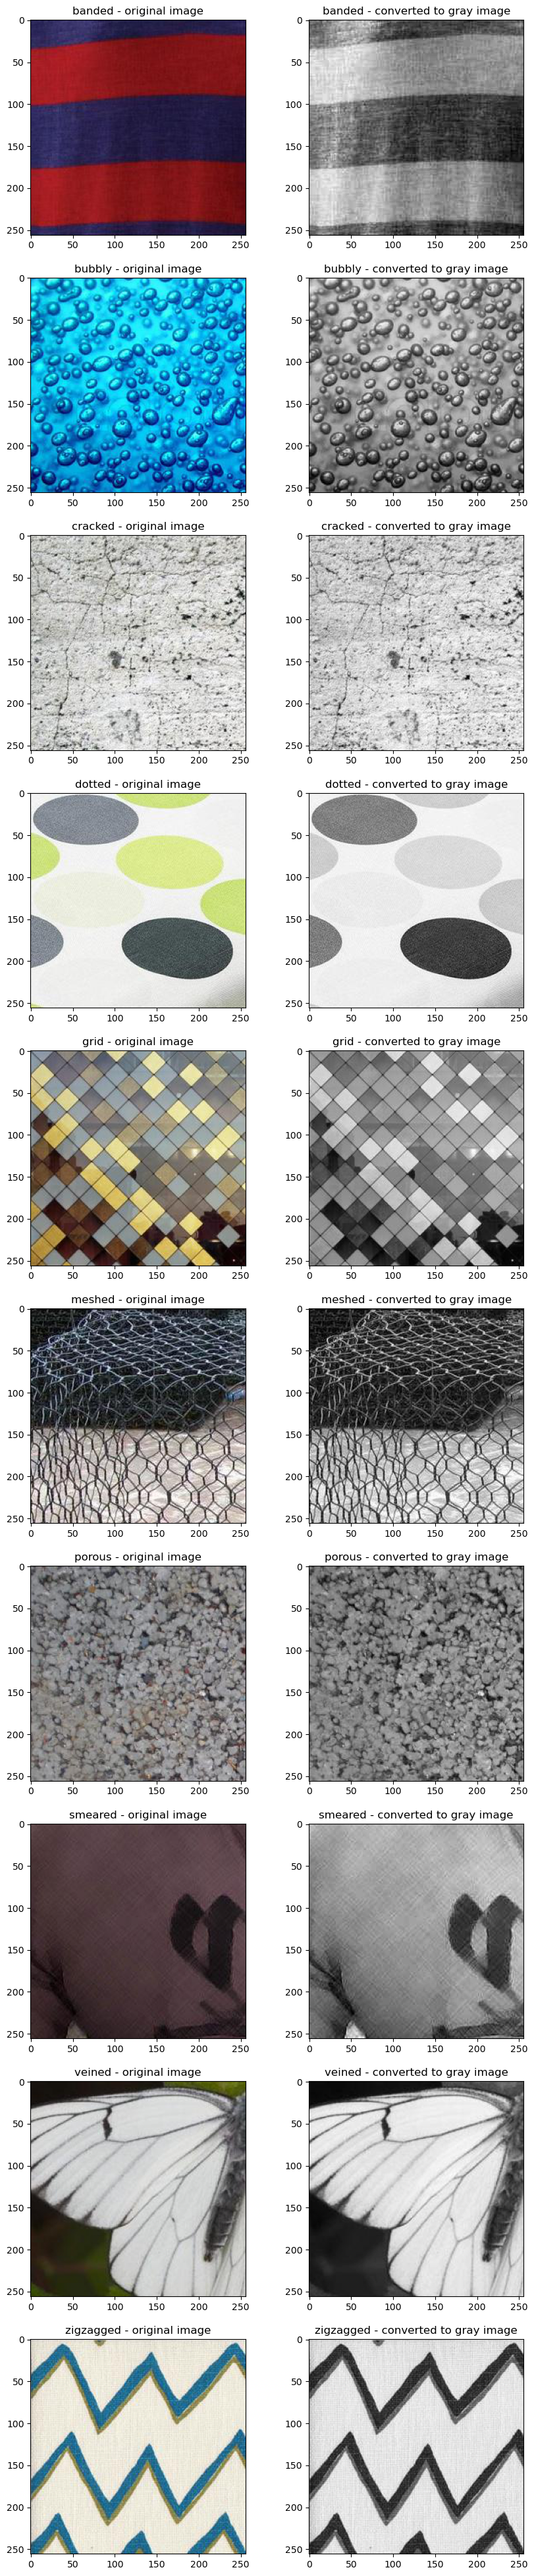

In [5]:
fig = plt.figure(figsize=(10,50))

imgs = []

i=0
for texture in textures:
    # load an image from dataset
    img = cv2.imread(f'dtd/images/{texture}/{texture}_0118.jpg')[0:256,0:256]

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(10, 2, 1+i*2)
    plt.imshow(rgb_img)
    plt.title(f"{texture} - original image")

    # convert to grey
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    imgs.append(gray_img)

    fig.add_subplot(10, 2, 2+i*2)
    plt.imshow(gray_img, cmap='gray')
    plt.title(f"{texture} - converted to gray image")
    
    i+=1

<AxesSubplot:>

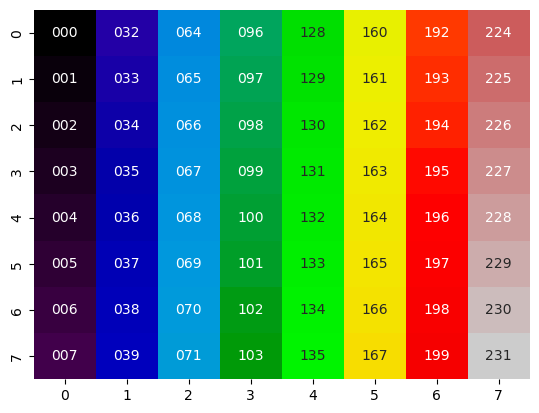

In [6]:
# divide the image up into unique tiles for further processing

mask = gray_img>0
    
xx, yy = np.meshgrid(
    np.arange(gray_img.shape[1]),
    np.arange(gray_img.shape[0]))

region_labels = (xx//32) * 32+yy//32
region_labels = region_labels.astype(int)

sns.heatmap(region_labels[::32, ::32].astype(int),
            annot=True,
            fmt="03d",
            cmap='nipy_spectral',
            cbar=False)

Analizowaliśmy kontrast, odmienność, homogeniczność, energię, korelację i drugi moment kątowy.

In [7]:
# compute GLCM properties each patch

out_df_list_of_img = []
prop_imgs_of_imgs = []
score_img_of_imgs = []
for gray_img in imgs:

    grayco_prop_list = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

    prop_imgs = {}
    for c_prop in grayco_prop_list:
        prop_imgs[c_prop] = np.zeros_like(gray_img, dtype=np.float32)
        
    score_img = np.zeros_like(gray_img, dtype=np.float32)
    out_df_list = []
    for patch_idx in np.unique(region_labels):
        xx_box, yy_box = np.where(region_labels == patch_idx)

        glcm = skimage.feature.graycomatrix(gray_img[xx_box.min():xx_box.max(), yy_box.min():yy_box.max()], [5], [0], 256, symmetric=True, normed=True)

        mean_score = np.mean(mask[region_labels == patch_idx])
        score_img[region_labels == patch_idx] = mean_score

        out_row = dict(
            intensity_mean=np.mean(gray_img[region_labels == patch_idx]),
            intensity_std=np.std(gray_img[region_labels == patch_idx]),
            score=mean_score)

        for c_prop in grayco_prop_list:
            out_row[c_prop] = skimage.feature.graycoprops(glcm, c_prop)[0, 0]
            prop_imgs[c_prop][region_labels == patch_idx] = out_row[c_prop]

        out_df_list += [out_row]

    out_df_list_of_img.append(out_df_list)
    prop_imgs_of_imgs.append(prop_imgs)
    score_img_of_imgs.append(score_img)


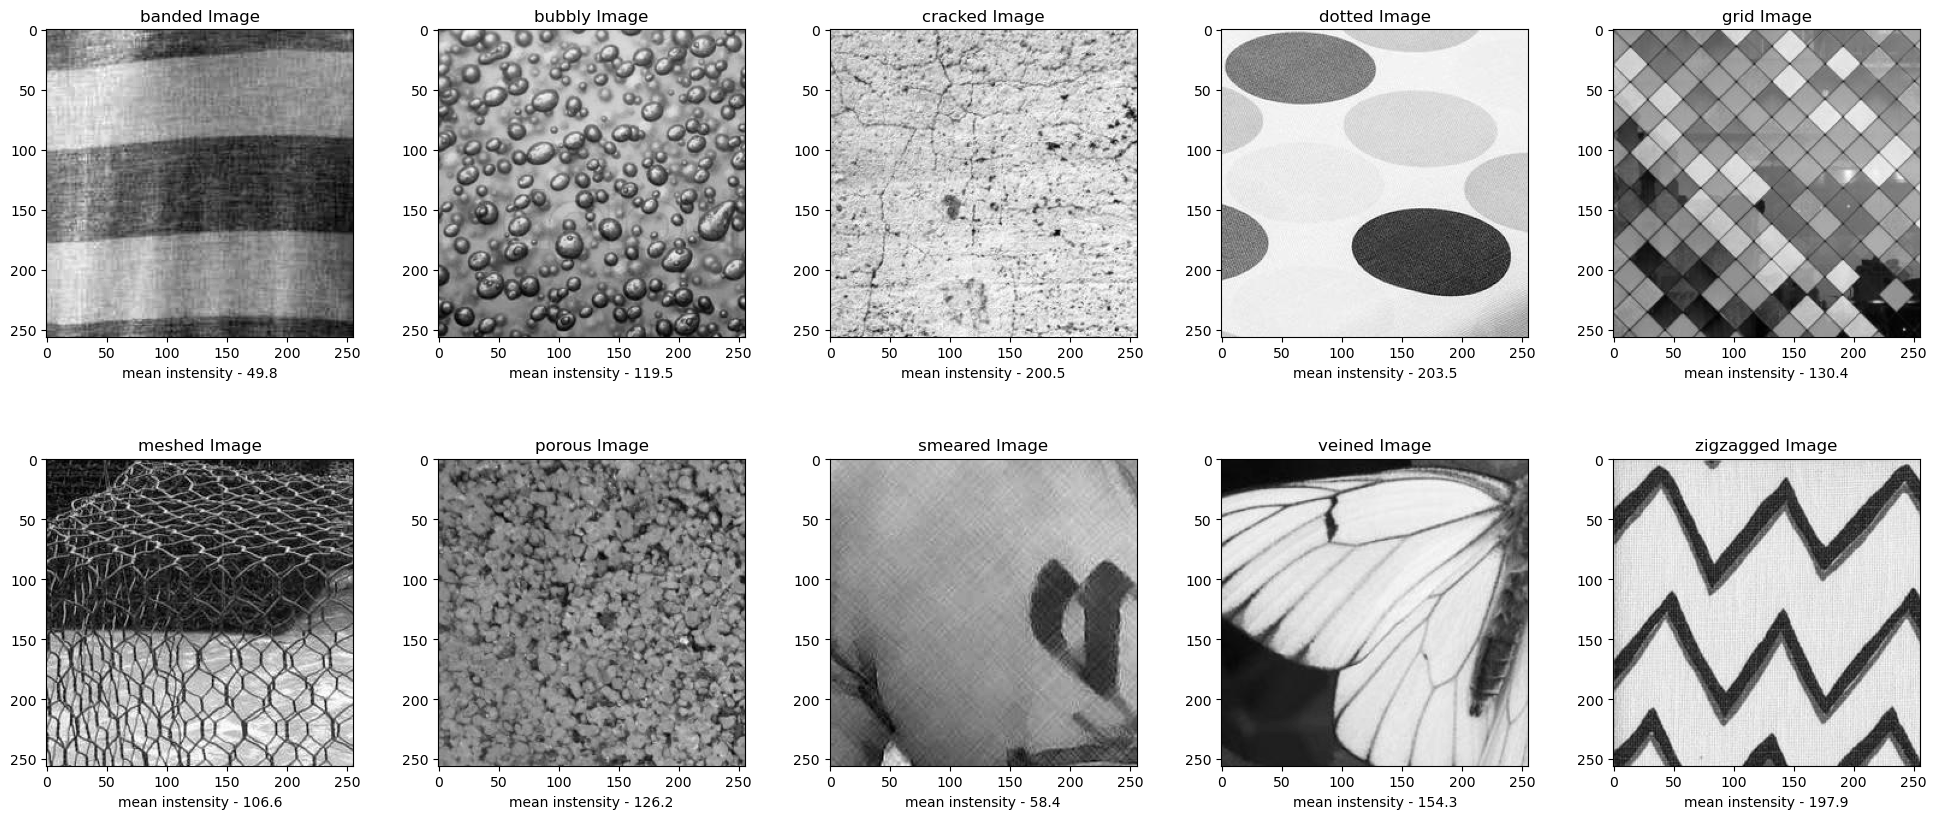

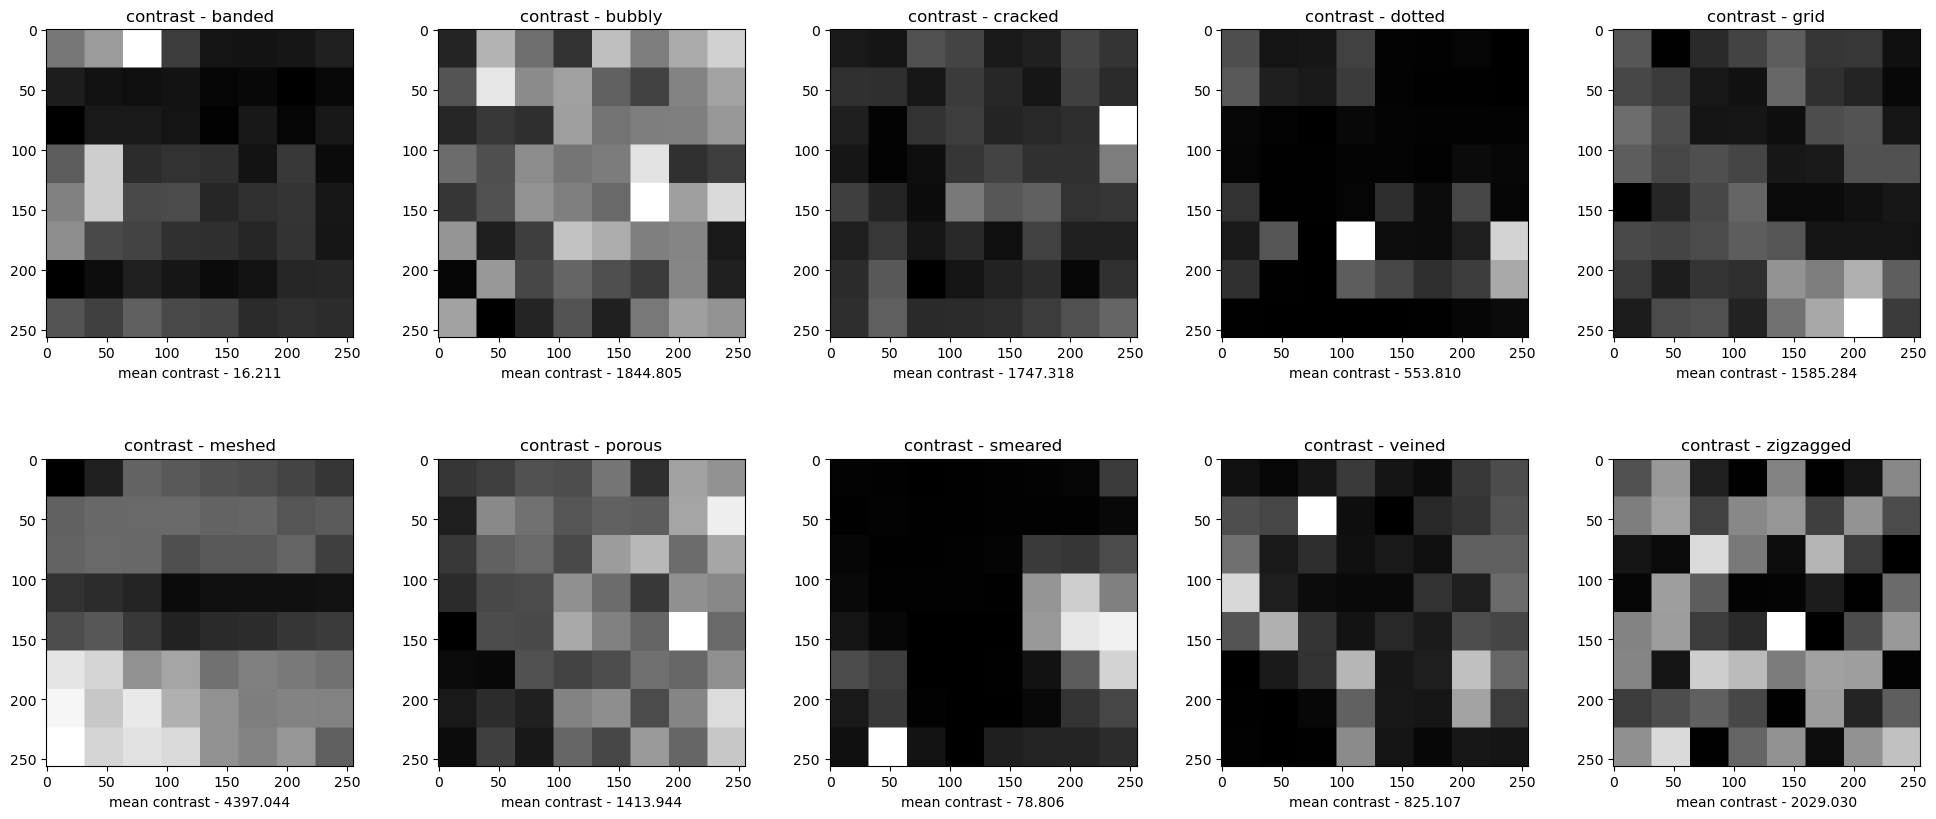

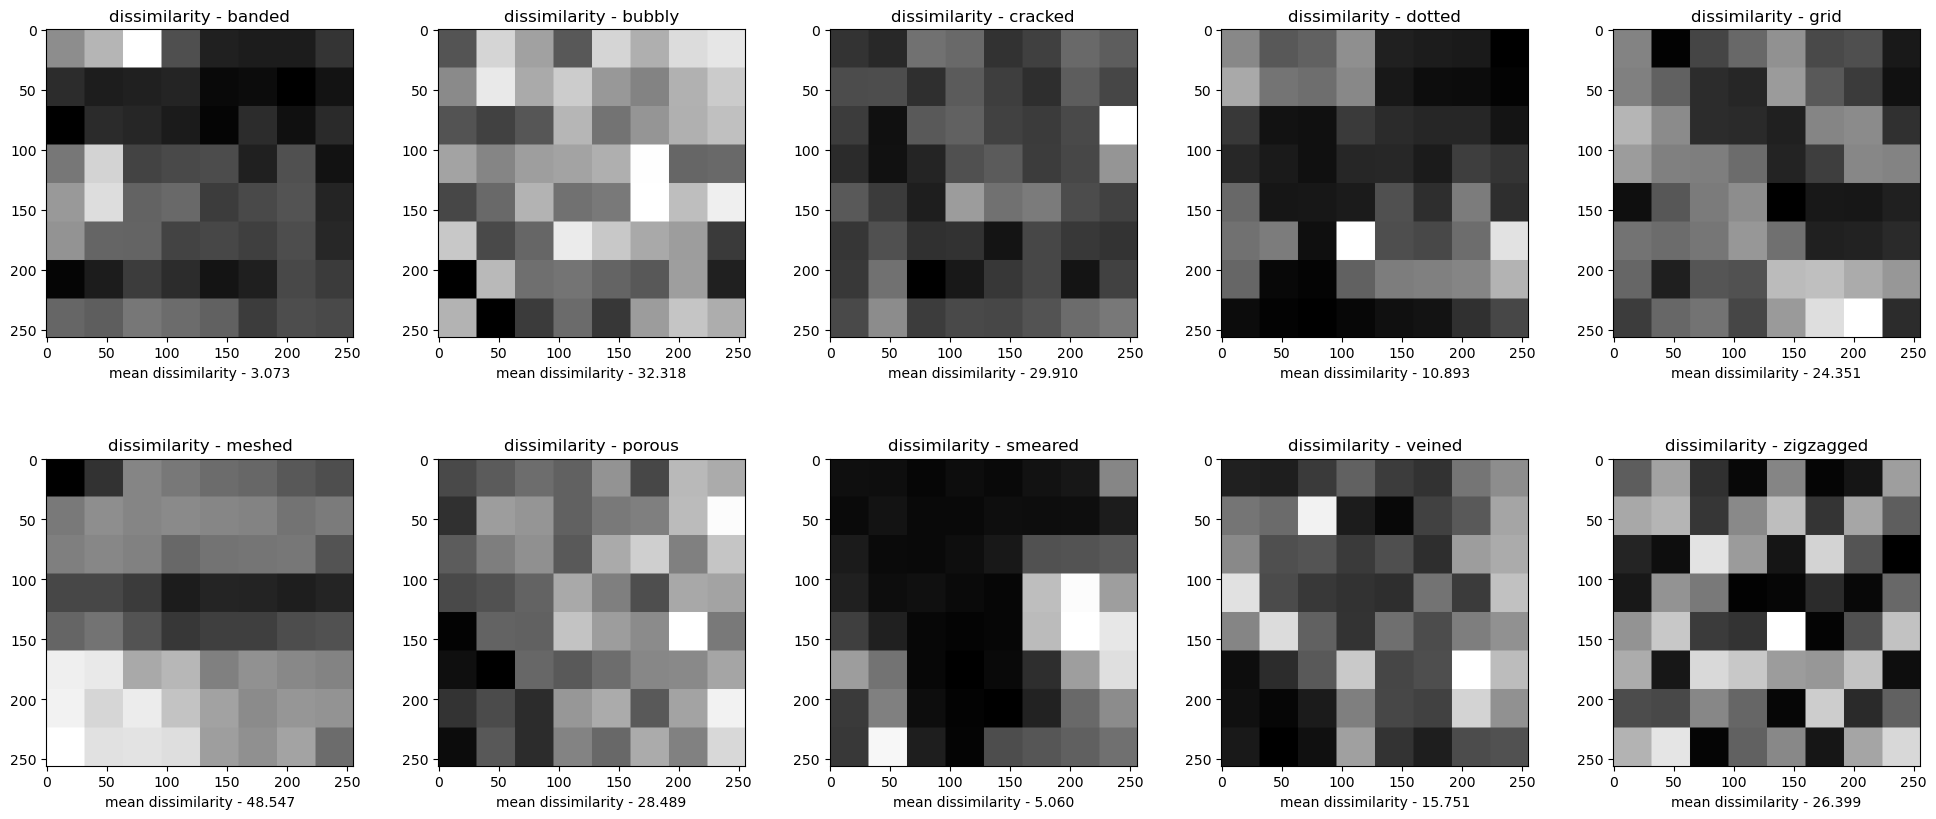

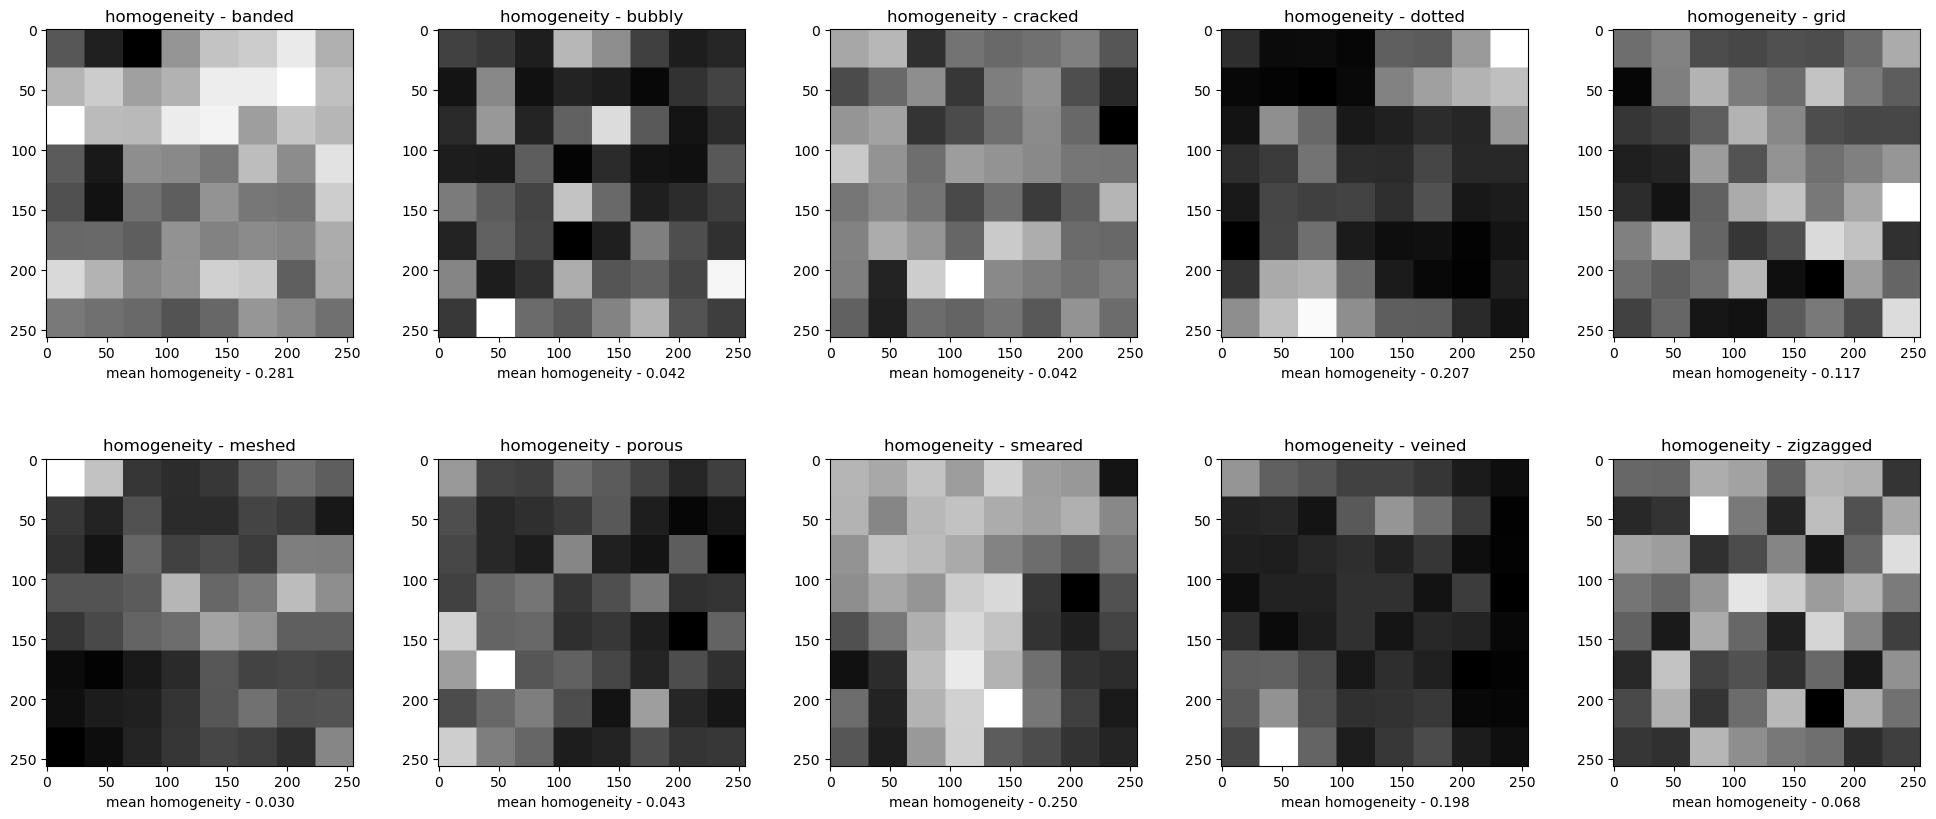

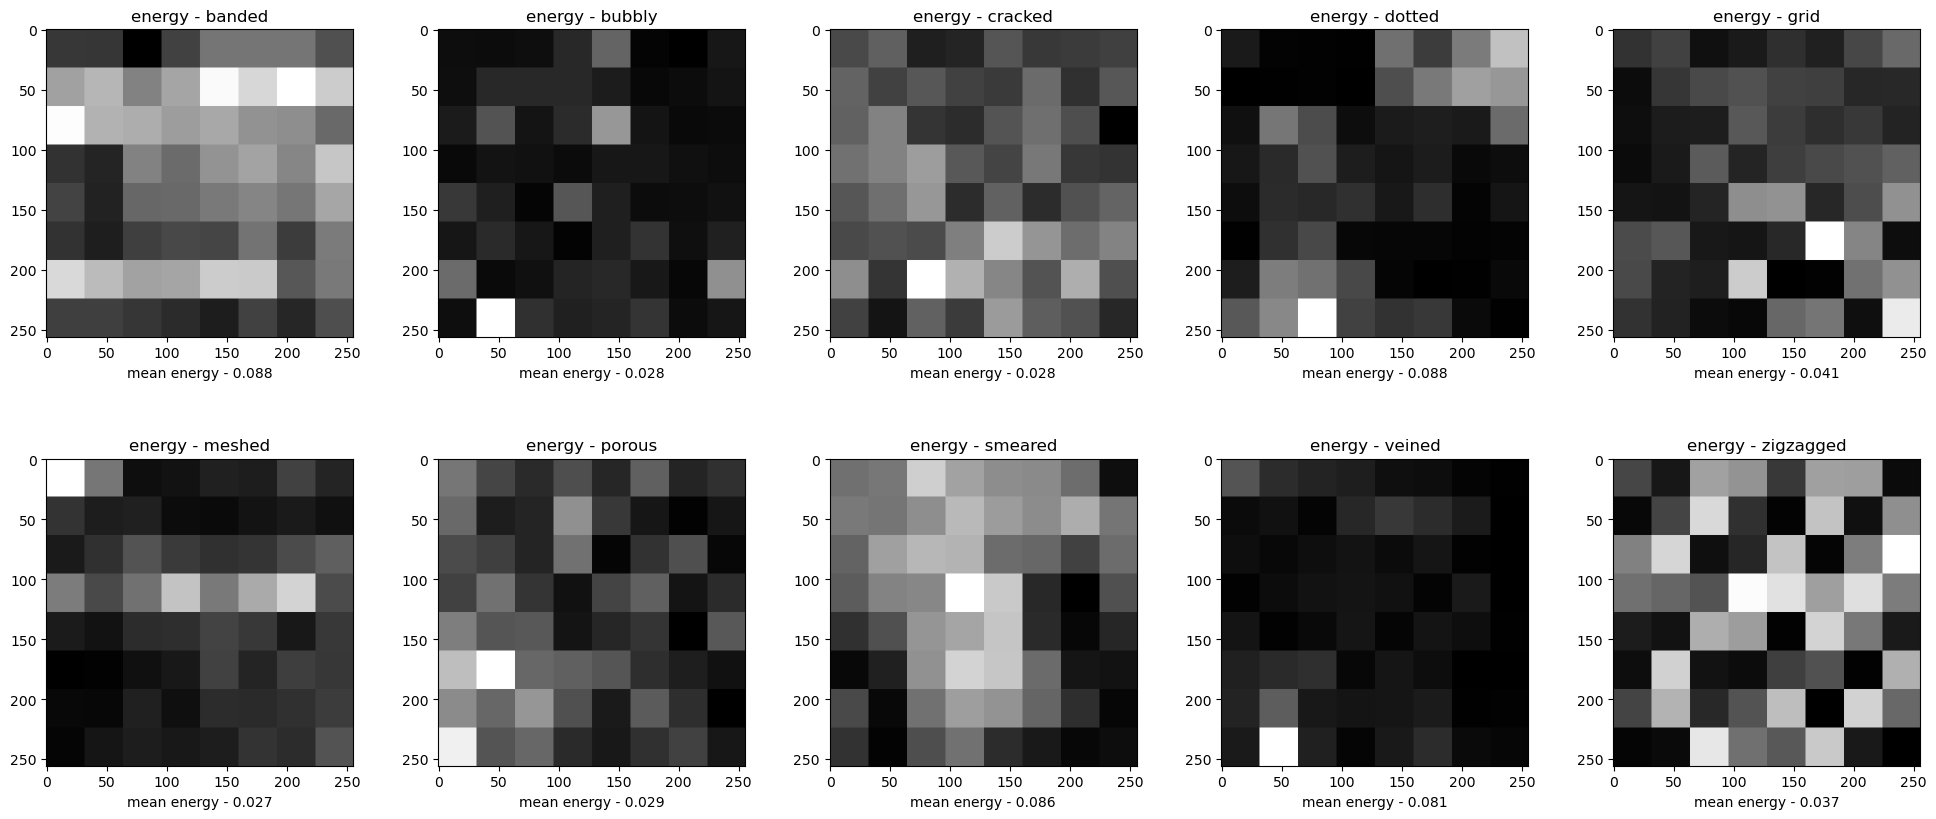

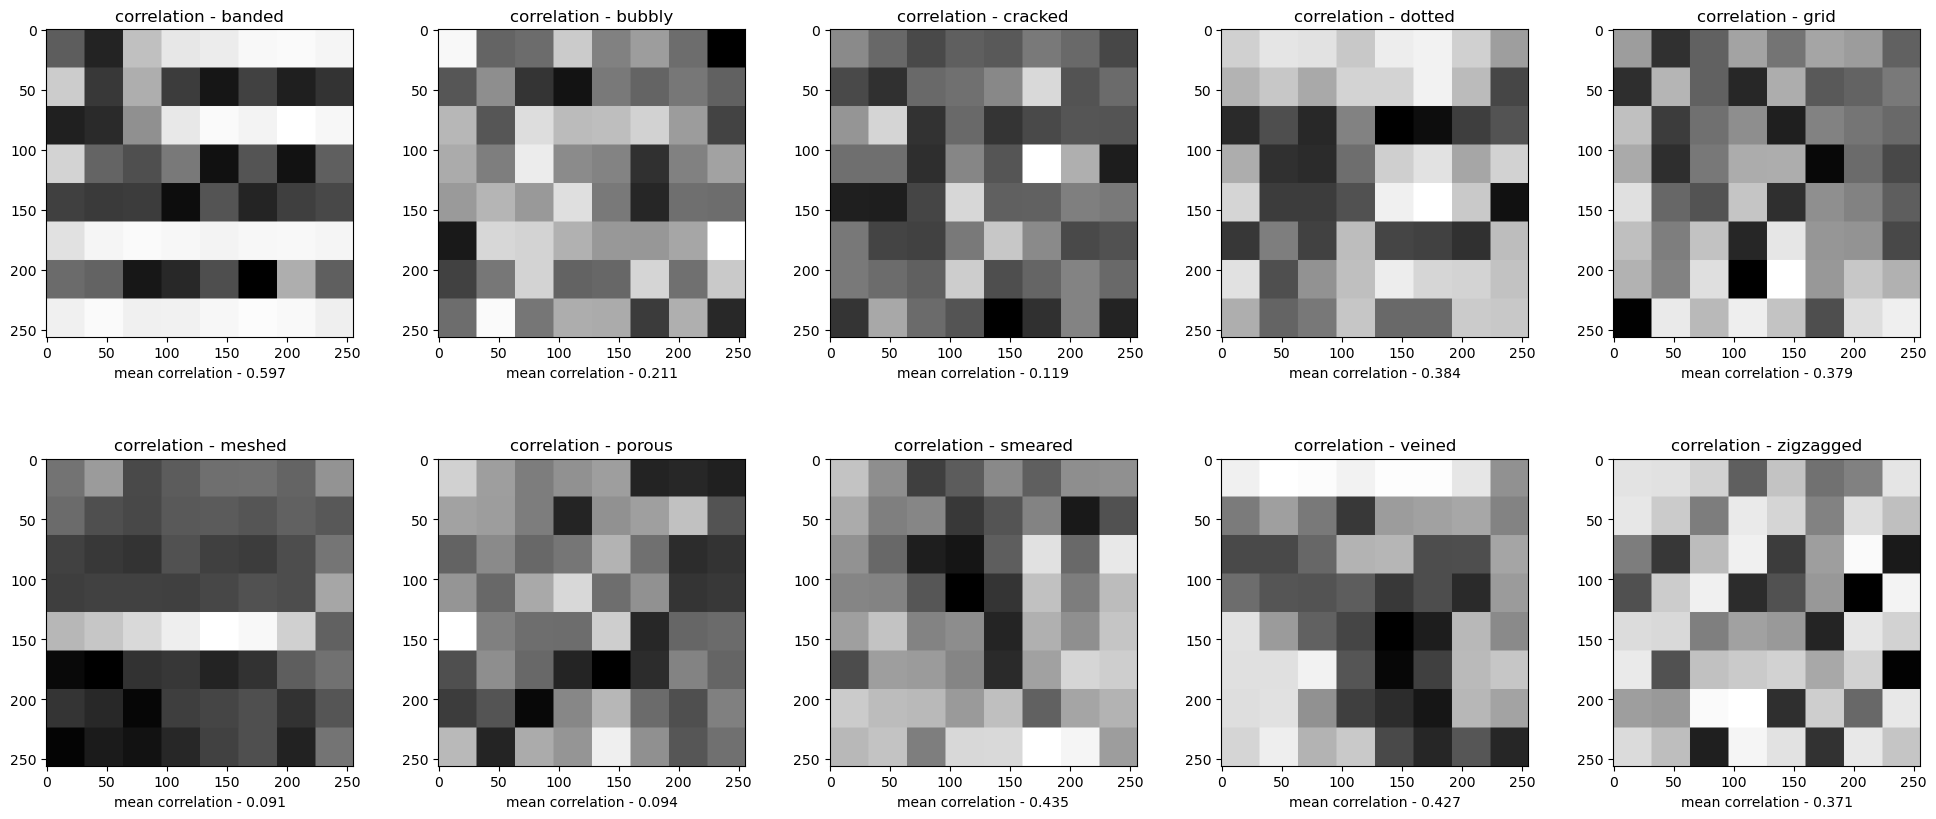

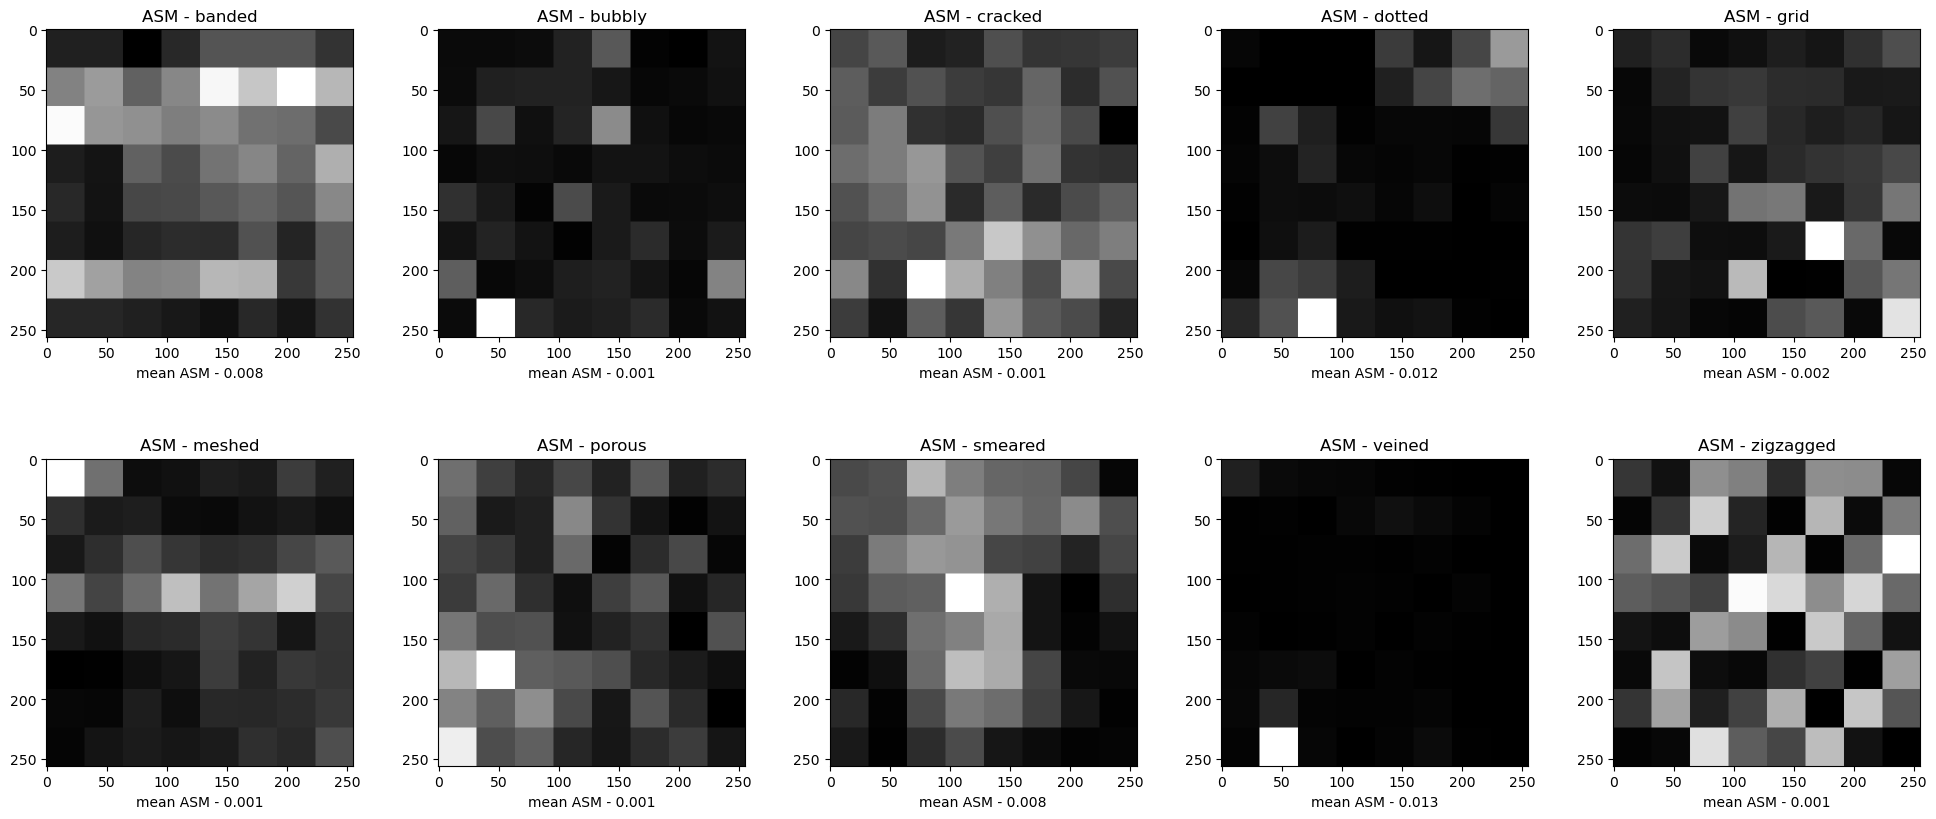

In [14]:
fig, m_axs = plt.subplots(2, 5, figsize=(20, 9))
n_axs = m_axs.flatten()
fig.tight_layout(pad=3)
for gray_img,c_ax, title, out_df_list in zip(imgs,n_axs, textures, out_df_list_of_img):
    out_df = pd.DataFrame(out_df_list)
    c_ax.imshow(gray_img, cmap='gray')
    c_ax.axis('on')
    c_ax.set_title(f'{title} Image')
    c_ax.set_xlabel(f'mean instensity - { out_df.describe().loc["mean"]["intensity_mean"]:.1f}')

for c_prop in grayco_prop_list:
    fig, m_axs = plt.subplots(2, 5, figsize=(20, 9))
    fig.tight_layout(pad=3)
    n_axs = m_axs.flatten()
    for prop_imgs,c_ax,title, out_df_list in zip(prop_imgs_of_imgs, n_axs, textures, out_df_list_of_img):
        out_df = pd.DataFrame(out_df_list)
        c_ax.imshow(prop_imgs[c_prop], cmap='gray')
        c_ax.axis('on')
        c_ax.set_title(f'{c_prop} - {title}')
        c_ax.set_xlabel(f'mean {c_prop} - { out_df.describe().loc["mean"][c_prop]:.3f}')

In [12]:
out_df_full = pd.DataFrame()
for out_df_list, texture in zip(out_df_list_of_img, textures):
    out_df = pd.DataFrame(out_df_list)
    out_df_full[texture] = out_df.describe().loc['mean']
    
display(out_df_full.transpose())

intensity_mean  intensity_std  score     contrast  dissimilarity  \
banded          49.798615       5.994469    1.0    16.211248       3.073182   
bubbly         119.483398      34.406946    1.0  1844.805424      32.317831   
cracked        200.472275      31.373001    1.0  1747.317618      29.909662   
dotted         203.453537      22.755908    1.0   553.810154      10.892544   
grid           130.387695      37.254011    1.0  1585.284022      24.350903   
meshed         106.623413      48.049968    1.0  4397.043599      48.546623   
porous         126.224182      27.719200    1.0  1413.944363      28.488640   
smeared         58.366318       8.097102    1.0    78.806200       5.060464   
veined         154.339401      31.214383    1.0   825.107281      15.751124   
zigzagged      197.868118      44.033295    1.0  2029.030378      26.398709   

           homogeneity    energy  correlation       ASM  
banded        0.280716  0.088134     0.597381  0.008282  
bubbly        0.042077  0.027982     0.210620  0.000787  
cracked       0.041639  0.028265     0.119472  0.000800  
dotted        0.207337  0.088410     0.383703  0.011974  
grid          0.117063  0.040725     0.378916  0.001743  
meshed        0.029716  0.026715     0.090530  0.000715  
porous        0.042532  0.028567     0.093657  0.000818  
smeared       0.250236  0.085709     0.435003  0.008241  
veined        0.197610  0.080617     0.426501  0.012594  
zigzagged     0.068423  0.036625     0.370969  0.001396

Dodatkowo zbadaliśmy wpływ szumu na wyniki.

TO DO

Jak również sprawdziliśmy, jak mała zmiana orientacji obrazu wpłynie na wynik.

TO DO

WNIOSKI:

TO DO